In [ ]:
!pip install gymnasium
!pip install 'gymnasium[atari]'
!pip install 'gymnasium[accept-rom-license]'

!pip install torch torchvision torchaudio
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

In [50]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Iterable

import gymnasium as gym
import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

In [51]:
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):

        super(DQN, self).__init__()

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)
        
        self.fc1 = nn.Linear(32*4*4, 128)
        self.fc2 = nn.Linear(128, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:            
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [52]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)
        
        return Q(obs).argmax().detach().numpy()
    return policy_fn

In [53]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    factor = current_timestep / duration
    eps = max(eps_start + factor * (eps_end - eps_start), eps_end)
    return eps

In [54]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        if self.__len__() < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)
            self.position = (self.position + 1) % self.max_size
        return 

    def sample(self, batch_size: int) -> torch.Tensor:
        rands = np.random.randint(0, self.__len__(), size = batch_size)
        
        obs_b = torch.stack([torch.from_numpy(self.data[i][0]) for i in rands])
        action_b = torch.stack([torch.tensor(self.data[i][1]) for i in rands ])
        reward_b = torch.stack([torch.tensor(self.data[i][2]) for i in rands])
        next_obs_b = torch.stack([torch.from_numpy(self.data[i][3]) for i in rands])
        terminated_b = torch.stack([torch.tensor(self.data[i][4]) for i in rands])
        return (obs_b, action_b, reward_b, next_obs_b, terminated_b)

In [ ]:
def update_ddqn(
        q1: nn.Module,
        q1_target: nn.Module,
        optimizer1: optim.Optimizer,
        q2: nn.Module,
        q2_target: nn.Module,
        optimizer2: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):

    # Calculate the TD-Target
    with torch.no_grad():
        # Double Q update
        max_action = torch.max(q1_target(next_obs), 1)
        # print(max_action)
        # print(q2_target(next_obs))
        q_value = torch.gather(q2_target(next_obs), 1, max_action.indices.unsqueeze(1)).flatten()
        # print(q_value)
        # print(rew)
        td_target = rew + q_value * gamma * (1-torch.Tensor(tm).float())

    
    for q, optimizer in [(q1, optimizer1), (q2, optimizer2)]:
        q.zero_grad()
        optimizer.zero_grad()
        pred = torch.gather(q(obs), 1, act.type(torch.int64).unsqueeze(1)).flatten()
        loss_fun = nn.MSELoss()
        loss = loss_fun(td_target, pred)
        loss.backward()
        optimizer.step()
    

In [ ]:
def polyak_update(
    params: Iterable[torch.Tensor],
    target_params: Iterable[torch.Tensor],
    tau: float,
) -> None:
    for param, target_param in zip(params, target_params):
        target_param.data.mul_(1 - tau)
        target_param.data.add_(param.data * tau)

<h1>DDQN</h1>

In [ ]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DDQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            tau = 0.005
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.tau = tau

        self.buffer = ReplayBuffer(maxlen)

        self.q1 = DQN(env.observation_space.shape, env.action_space.n)
        self.q2 = DQN(env.observation_space.shape, env.action_space.n)

        self.q1_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q1_target.load_state_dict(self.q1.state_dict())

        self.q2_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q2_target.load_state_dict(self.q2.state_dict())

        self.optimizer1 = optim.Adam(self.q1.parameters(), lr = lr)
        self.optimizer2 = optim.Adam(self.q2.parameters(), lr = lr)

        self.policy_1 = make_epsilon_greedy_policy(self.q1, env.action_space.n)
        self.policy_2 = make_epsilon_greedy_policy(self.q2, env.action_space.n)

    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start
        
        for i_episode in range(num_episodes):
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}  Transitions: {len(self.buffer)}')

            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)
                
                if(i_episode % 2 == 0):
                    action = self.policy_1(torch.as_tensor(obs).unsqueeze(0).float(), epsilon)
                else:
                    action = self.policy_2(torch.as_tensor(obs).unsqueeze(0).float(), epsilon)
                    
                next_obs, reward, terminated, truncated, _ = self.env.step(action)
                
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(obs, action, reward, next_obs, terminated)
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)
                
                # Update the Q network
                if(i_episode % 2 == 0):
                    update_ddqn(
                        self.q2,
                        self.q2_target,
                        self.optimizer2,
                        self.q1,
                        self.q1_target,
                        self.optimizer1,
                        self.gamma, 
                        obs_batch.float(),
                        rew_batch.float(),
                        act_batch,
                        next_obs_batch.float(),
                        tm_batch
                    )
                else:
                    update_ddqn(
                        self.q1,
                        self.q1_target,
                        self.optimizer1,
                        self.q2,
                        self.q2_target,
                        self.optimizer2,
                        self.gamma,
                        obs_batch.float(),
                        rew_batch.float(),
                        act_batch,
                        next_obs_batch.float(),
                        tm_batch
                    )

                polyak_update(self.q1.parameters(), self.q1_target.parameters(), self.tau)
                polyak_update(self.q2.parameters(), self.q2_target.parameters(), self.tau)
                current_timestep += 1

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [133]:
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit

LR = 0.001
BATCH_SIZE = 64
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 150
EPS_START = 0.75
EPS_END = 0.02
SCHEDULE_DURATION = 100_000
NUM_EPISODES = 200
DISCOUNT_FACTOR = 0.99
TAU = 0.01

# Even though I played around with the hyperparameters I was not able to achieve a better result than
# the original set.

# Train DDQN
agent = DDQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    tau = TAU
)
stats = agent.train(NUM_EPISODES)

Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)



c:\Users\U755531\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 100 of 200  Time Step: 5516  Epsilon: 0.710  Transitions: 5516
Episode 200 of 200  Time Step: 11387  Epsilon: 0.667  Transitions: 11387


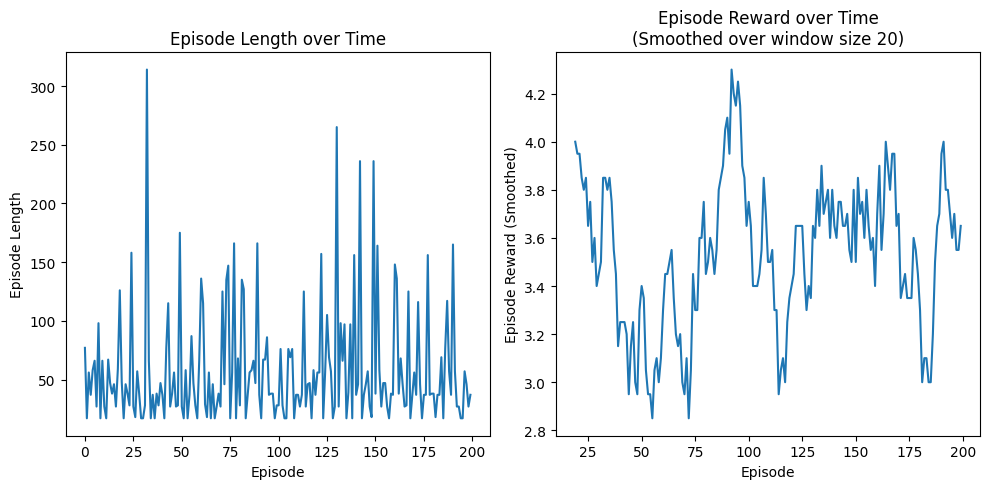

In [134]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time") 

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()


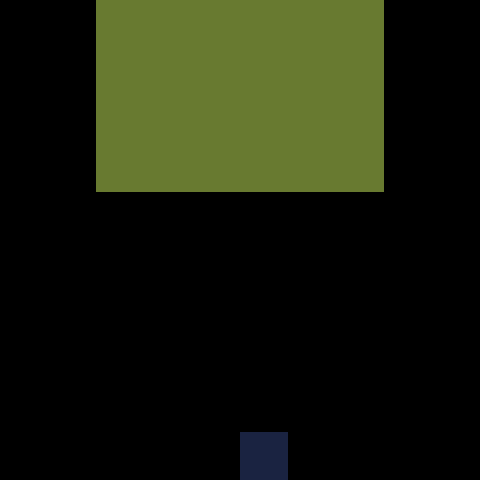

In [139]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q2, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")